[INFO] Loading image captioning model...
[INFO] Generating caption...
[INFO] Performing segmentation...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[INFO] Displaying results...


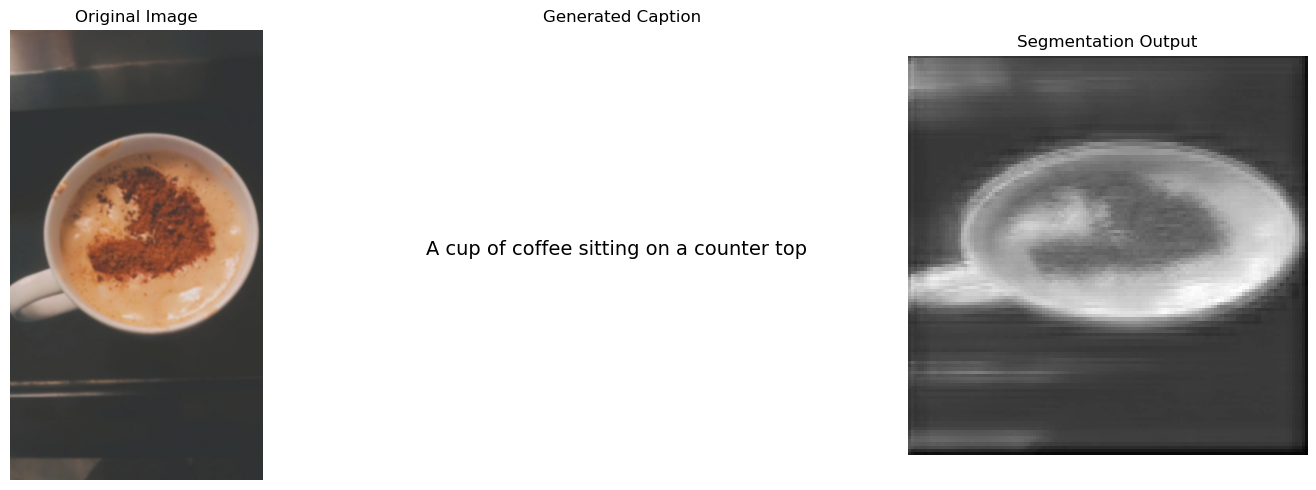

In [6]:
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# load real caption model
print("[INFO] Loading image captioning model...")

caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = "cuda" if torch.cuda.is_available() else "cpu"
caption_model.to(device)

def generate_caption(image_path):
    img = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = caption_model.generate(pixel_values, max_length=16)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption.capitalize()

# simple U-NET model for segmentation
def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)

    u1 = UpSampling2D((2, 2))(c3)
    m1 = concatenate([u1, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = UpSampling2D((2, 2))(c4)
    m2 = concatenate([u2, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# image processing with display
def preprocess_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    return img / 255.0

def show_results(original_img_path, caption, mask):
    original = cv2.imread(original_img_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Generated Caption")
    plt.text(0.01, 0.5, caption, fontsize=14)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Segmentation Output")
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# main runner
def run_pipeline(image_path):
    print("[INFO] Generating caption...")
    caption = generate_caption(image_path)

    print("[INFO] Performing segmentation...")
    image = preprocess_image(image_path)
    image_input = np.expand_dims(image, axis=0)

    model = build_unet()
    # You can load pre-trained weights here if you have them
    predicted_mask = model.predict(image_input)

    print("[INFO] Displaying results...")
    show_results(image_path, caption, predicted_mask)

#execution
run_pipeline("C:/Users/gouri/OneDrive/Pictures/Camera Roll/WhatsApp Image 2025-01-26 at 22.05.03_4949d144.jpg")  # replace with your image path
